# Temporal Difference vs. Monte Carlo Learning

Temporal difference (TD) and Monte Carlo (MC) methods appears all over the place in reinforcement learning (RL). While they could seemingly not be more different, they really represent two sides of the same coin. This notebook will explore the commonalities and differences between these two approaches to RL and compare them on a simple prediction task.

## Introduction

Both TD-learning and MC-learning are really moreso paradigms or ideas than algorithms. For demonstration purposes, we will use two algorithms called TD-prediction and MC-prediction, though there are many other algorithms based on the same ideas. In both cases, the task is simple: we are in an environment and given some policy $\pi$. Our goal is to find or estimate the so-called value function $v_{\pi}$. This function represents the expected cumulative discounted reward that the agent will receive when starting in that state and taking actions following $\pi$.

$$
v_{\pi}(s) = \mathbb{E}_{\pi}\left[\sum_{k=0}^{\infty}\gamma^k R_{t+1+k} \mid S_t = s\right]
$$

We can rewrite the equation above slightly to obtain a recursive relationship between successive states.

$$
v_{\pi}(s) = \mathbb{E}_{\pi}\left[R_{t+1} + \gamma v_{\pi}(S') \mid S_t = s\right]
$$

This is also known as (one of) the Bellman equation(s), and will turn out to be very useful in a second.

### TD-Prediction

The basic idea behind TD-prediction is simple. We start with some random estimate of the value function $\hat{v}_{\pi}$ with parameters $\theta$. While acting according to our policy, we then observe states, actions, and rewards, and use those to perform the following update.

$$
\theta \leftarrow \theta + \alpha \left[ R + \gamma \hat{v}_{\pi}(S') - \hat{v}_{\pi}(S) \right] \nabla \hat{v}_{\pi}(S)
$$

where the gradient is taken with respect to $\theta$. The variable $\alpha$ is called the *learning rate* and is just some small constant here, though it is not uncommon to decay it over time. This update attempts to narrow the difference between a states value and the *target* $R_{t+1} + \gamma v_{\pi}(S')$ at every step. Over time, the differences get smaller and smaller, and it is easy to see that the fixed point of these updates satisfies the Bellman equation from earlier! If reached, this would mean that we found the true value function.

Using Python and TensorFlow 2.0, we can implement this as follows. `policy` is a `tf.keras.Model` object that was assume to be given.

```python
for i in range(num_episodes):
    state = env.reset().reshape(1, -1)
    done = False
    while not done:
        action = np.random.choice(num_actions, p=policy(state))
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.reshape(1, -1)

        # Compute TD error
        if done:
            target = reward
        else:
            target = reward + gamma * value_fn(next_state)
        delta = target - value_fn(state)

        # Compute gradient
        weights = value_fn.trainable_weights
        with tf.GradientTape() as tape:
            value = value_fn(state)
        grads = tape.gradient(value, weights)

        # Update weights
        for w, g in zip(weights, grads):
            dw = tf.reshape(alpha * delta * g, w.shape)
            w.assign_add(dw)

        state = next_state
```

A full version can be found [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/semi_gradient_td_prediction.py).

### MC-Prediction

MC-prediction takes a different approach to the problem. Typically, updates are done on an episode-by-episode basis. We roll out an episode following $\pi$, and then compute the return $G_t$ at every time step as

$$
G_t = \sum_{k=0}^{\infty}\gamma^k R_{t+1+k}
$$

Recall this quantity from the definition of the value function earlier. The algorithm is shown as pythonic pseudo-code below. Then, we use the return to perform the update

$$
\theta \leftarrow \theta + \alpha \left[ G_t - \hat{v}_{\pi}(S) \right] \nabla \hat{v}_{\pi}(S)
$$

This looks similar to the TD update above! And it is exactly equivalent to averaging the observed returns, as long as we start with values of 0 and decay $\alpha$ according to $\alpha_t = \frac{1}{t}$. The corresponding Python code is shown below and a full version can be found [here](https://github.com/christopher-wolff/rlsuite/blob/master/rlsuite/algos/gradient_mc_prediction.py).

```python
for i in range(num_episodes):
    # Roll out an episode
    experience = []
    state = env.reset()
    done = False
    while not done:
        action = np.random.choice(num_actions, p=policy(state))
        next_state, reward, done, _ = env.step(action)
        experience.append((state, reward))
        state = next_state

    G = 0
    for state, reward in reversed(experience):
        # Convert state to one-element batch
        state = state.reshape(1, -1)

        # Compute return
        G = gamma * G + reward

        # Compute gradient
        weights = value_fn.trainable_weights
        with tf.GradientTape() as tape:
            value = value_fn(state)
        grads = tape.gradient(value, weights)

        # Update weights
        for w, g in zip(weights, grads):
            dw = tf.reshape(alpha * (G - value) * g, w.shape)
            w.assign_add(dw)
```

## Experiments

To see some of the differences between the two algorithms, we will conduct a simple experiment. The task is the following: the agent starts in the middle of a corridor, where it can move to the left and right. If it goes to the left, it will eventually reach the end, causing the episode to terminate with a total reward of $0$. If it goes to the right, the episode will also terminate, but in the final state it will achieve a reward of $+1$. The task is *undiscounted*, that is $\gamma = 1$.

<img src="imgs/random_walk.png" style="width: 500px"/>

<center>Image credit: Sutton & Barto (2018)</center>

The agent itself acts completely at random, choosing either action with equal probability. Instead of the five states shown in the figure above, we will use a slightly longer corridor of 15 states. Each observation in this environment is just a one-hot vector indicating the current state. That is, a vector of the same length as the state space, with a 1 at the index of the current state and zeros elsewhere. We start with TD-prediction.

In [1]:
import gym
import numpy as np
import tensorflow as tf
from gym.envs.registration import register

from rlsuite.algos import semi_gradient_td_prediction
from rlsuite.algos import gradient_mc_prediction
from rlsuite.envs import random_walk

In [2]:
ENV = 'RandomWalk-v1'
NUM_STATES = 5
NUM_EPISODES = 1000
ALPHA = 0.1
GAMMA = 1
SEED = 0

register(
    id='RandomWalk-v1',
    entry_point='rlsuite.envs.random_walk.random_walk:RandomWalk',
    kwargs={'num_states': NUM_STATES},
    max_episode_steps=50,
)
random_policy = lambda *args, **kwargs: [0.5, 0.5]

In [4]:
td_value_fn = semi_gradient_td_prediction(
    env_fn=lambda: gym.make(ENV),
    policy=random_policy,
    value_fn=tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(NUM_STATES+2,), activation='linear'),
    ]),
    alpha=ALPHA,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    data_dir='/tmp/tests/random_walk_td',
    seed=SEED,
)

Note that the input to our value function requires `NUM_STATES + 2` numbers. These extra states are the goal states on the far left and far right of the corridor.

In [6]:
mc_value_fn = gradient_mc_prediction(
    env_fn=lambda: gym.make(ENV),
    policy=random_policy,
    value_fn=tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(NUM_STATES+2,), activation='linear'),
    ]),
    alpha=ALPHA,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    data_dir='/tmp/tests/random_walk_mc',
    seed=SEED,
)

To visualize the results, we will take a look at the final policies. We also compare them to the true policy, which can quite easily be computed explicitely using some probability theory. It should be easy to see that without discounting, the center state has value 0.5. The left- and right-most states have probabilities 0 and 1, respectively, and it turns out that the true value function is linear with respect to the state number.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_value(state, value_fn):
    obs = np.zeros(NUM_STATES + 2)
    obs[state] = 1
    return value_fn(obs.reshape(1, -1)).numpy().item()

states = range(NUM_STATES + 2)
td_values = np.array([get_value(state, td_value_fn) for state in states])
mc_values = np.array([get_value(state, mc_value_fn) for state in states])
true_values = np.linspace(0, 1, NUM_STATES + 2)

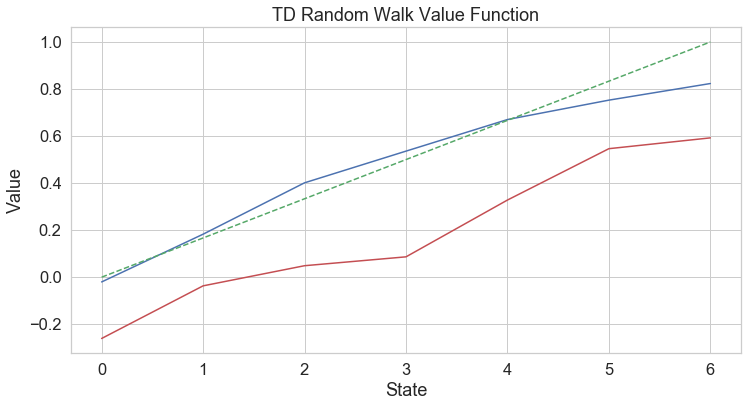

In [11]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(12, 6))
plt.plot(states, td_values, 'b-', states, mc_values, 'r-', states, true_values, 'g--')
plt.title('TD Random Walk Value Function')
plt.xlabel('State')
plt.ylabel('Value')
plt.show()

TODO: Discussion of results, plot of RMS error vs. iteration

## Conclusion

TODO: Discussion of tradeoffs